# Init Working Directory

In [62]:
import os

cwd = os.getcwd()

if cwd.endswith('prototype'):
    PATH = os.path.join('..', 'data', 'handwritten-hanacaraka')
    os.chdir(PATH)
    new_cwd = os.getcwd()

    print(f"The current working directory was: {cwd}")
    print(f"It has been changed to: {new_cwd}")

else:
    print(f"The current working directory is: {cwd}")

The current working directory is: C:\Users\Helmy\hanacaraka-classifier\data\clean-hanacaraka


# Removing Corrupted Datas

In [63]:
from PIL import Image

subdirs = [d for d in os.listdir() if os.path.isdir(d)]

image_files = []
for subdir in subdirs:
    image_files.extend([os.path.join(subdir, f) for f in os.listdir(subdir) if f.endswith('.png')])

print(f'Number of image files: {len(image_files)}\n')

Number of image files: 1562



In [64]:
corrupted_files = []
for image_file in image_files:
    try:
        img = Image.open(image_file)
    except:
        corrupted_files.append(image_file)

print(f'Number of corrupted files: {len(corrupted_files)}\n')

Number of corrupted files: 0



In [65]:
image_files = [f for f in image_files if f not in corrupted_files]

print(f'Number of image files after removing corrupted files: {len(image_files)}\n')

Number of image files after removing corrupted files: 1562



# Create New Directory for Selected Datas (Non-corrupted)

In [66]:
import shutil
import os

if (os.getcwd().endswith('handwritten-hanacaraka') 
        and not 
        os.path.exists(os.path.join('..', 'clean-hanacaraka'))):
    new_dir = os.path.join('..', 'clean-hanacaraka')

    for image_file in image_files:
        if os.name == 'nt':
            subdir, filename = image_file.split('\\')
        else:
            subdir, filename = image_file.split('/')
        subdir_path = os.path.join(new_dir, subdir)
        os.makedirs(subdir_path, exist_ok=True)
        new_filename = f'{subdir}_{len(os.listdir(subdir_path)) + 1}.png'
        shutil.copy(image_file, os.path.join(subdir_path, new_filename))

change the working directory to the new directory

In [67]:
os.chdir(new_dir)
new_cwd = os.getcwd()

print(f"The current working directory were: {new_cwd}")

The current working directory were: C:\Users\Helmy\hanacaraka-classifier\data\clean-hanacaraka


# Image Preprocessing

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

the image were not clean, so we need to preprocess the image. Example of unclean image:

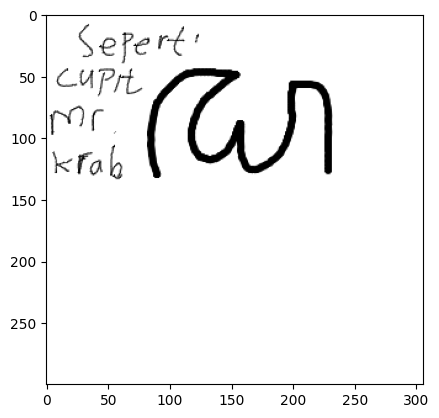

In [69]:
sample_img = ("dha\dha_21.png")
sample_img = cv2.imread(sample_img, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_img, cmap='gray')
plt.show()

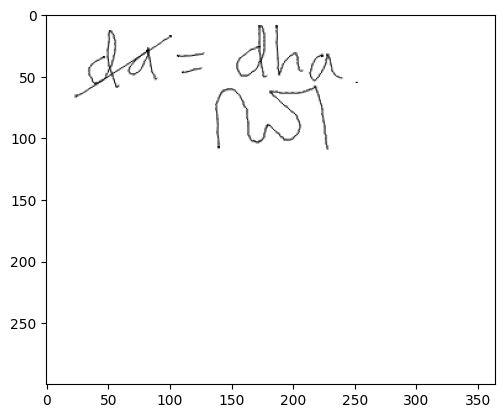

In [70]:
sample_img = ("dha\dha_37.png")
sample_img = cv2.imread(sample_img, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_img, cmap='gray')
plt.show()

function for preprocess the image

In [71]:
def cvt_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [72]:
def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.erode(img, kernel, iterations=1)

In [73]:
def normalize_img(img):
    return (img / 255.0 * 255).astype(np.uint8)

pipeline for preprocess the image

In [74]:
preprocess_timeline = [
    cvt_grayscale,
    erode_img,
    normalize_img,
]

In [75]:
def preprocess_img(path):
    image_file = cv2.imread(path)
    num_of_process = len(preprocess_timeline) + 1
    
    fig, axs = plt.subplots(num_of_process, 1, figsize=(5, 5*num_of_process))
    fig.suptitle('Preprocessing Timeline',                 
                 fontsize=20,
                 fontweight='bold',
                 )
    
    axs[0].imshow(image_file, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    for i in range(1, num_of_process):
        _temp_img = preprocess_timeline[i-1](image_file)
        image_file = _temp_img
        axs[i].imshow(_temp_img, cmap='gray')
        axs[i].set_title(preprocess_timeline[i-1].__name__)
        axs[i].axis('off')
        
    fig.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
    
    for ax in axs:
        ax.set_title(ax.get_title(), fontweight='semibold', fontsize='x-large')
        ax.label_outer()

    plt.subplots_adjust(top=0.95)

    plt.show()

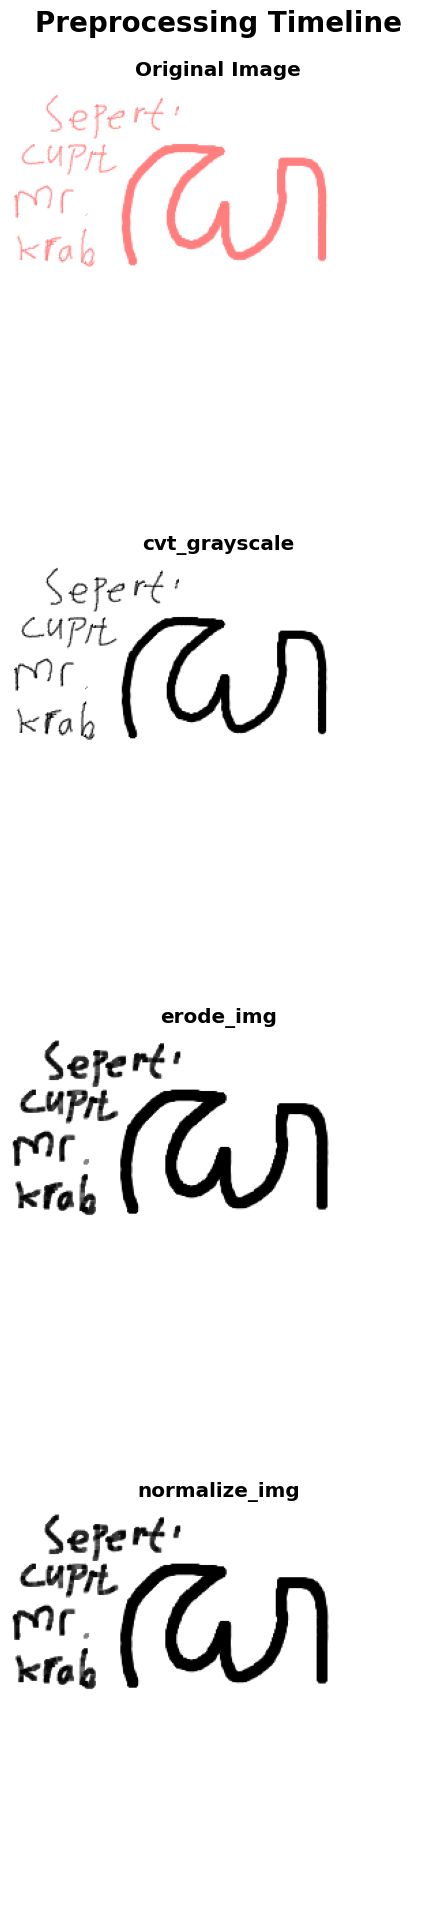

In [76]:
sample_img = ("dha\dha_21.png")

preprocess_img(sample_img)

# Computer Vision Timee

The baseline model will be cnn, so we need to do lot of data augmentation to the image

In [77]:
import torchvision.transforms as transforms
import torch.nn
import torch
import torch.optim
import torch.nn.functional as F
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

Create Dataset Class

the data were multi class, so we need to encode the label. We will use one hot encoding for this. The label will be the index of the class. Dont forget to save it as dictionary for later use

the folder will be like this

{label}/{image_name}.png // ba/ba_1.png

In [78]:
image_names, labels = [], []
for subdir in os.listdir():
    for image_name in os.listdir(subdir):
        image_names.append(image_name)
        labels.append(subdir)

label_dict = {label: i for i, label in enumerate(set(labels))}
label_dict

{'na': 0,
 'nga': 1,
 'sa': 2,
 'ba': 3,
 'ga': 4,
 'ka': 5,
 'ma': 6,
 'da': 7,
 'pa': 8,
 'ca': 9,
 'nya': 10,
 'ta': 11,
 'ja': 12,
 'dha': 13,
 'ra': 14,
 'la': 15,
 'wa': 16,
 'ha': 17,
 'ya': 18,
 'tha': 19}

In [79]:
import pandas as pd

df = pd.DataFrame({'image_name': image_names, 'label': labels})

In [80]:
df.sample(20)

,image_name,label
1077,pa_61.png,pa
767,ma_66.png,ma
375,ga_65.png,ga
1551,ya_71.png,ya
1103,ra_15.png,ra
368,ga_59.png,ga
1443,wa_45.png,wa
554,ka_15.png,ka
216,da_62.png,da
1317,ta_7.png,ta


In [81]:
X_train, x_val, y_train, y_val = train_test_split(
    df['image_name'], df['label'],
    test_size=0.2, random_state=42,
    stratify=df['label'].values
)

X_val, X_test, y_val, y_test = train_test_split(
    x_val, y_val,
    test_size=0.5, random_state=42,
    stratify=y_val
)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.shape, x_val.shape, X_test.shape

((1249,), (313,), (157,))

In [82]:
class HanacarakaDataset(Dataset):
    def __init__(self, x, y, maps_label=label_dict, transform=None):
        self.X = x
        self.y = y
        self.dicts = maps_label
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.y[idx]
        label = self.get_label(label)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def get_label(self, idx):
        label_id = None
        for key, values in self.dicts.items():
            if idx == key:
                label_id = values
        return label_id

    def __len__(self):
        return len(self.X)

In [83]:
def cvt_grayscale(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    return Image.fromarray(img)

def cvt_rgb(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    img = cv2.erode(np.array(img), kernel, iterations=1)
    return Image.fromarray(img)

def adaptive_threshold(img):
    img = cv2.adaptiveThreshold(np.array(img), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(img)
    
train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    # transforms.Lambda(erode_img),
    transforms.Lambda(adaptive_threshold),
    transforms.RandomRotation(10, fill=255),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    # transforms.RandomAdjustSharpness(2),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0), fill=255, ratio=(0.75, 1.3333333333333333)),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    # transforms.Lambda(erode_img),
    transforms.Lambda(adaptive_threshold),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

train_dataset = HanacarakaDataset(X_train, y_train, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = HanacarakaDataset(X_val, y_val, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = HanacarakaDataset(X_test, y_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [84]:
feature, label = next(iter(train_loader))
feature.shape, len(train_loader)

(torch.Size([64, 3, 100, 100]), 20)

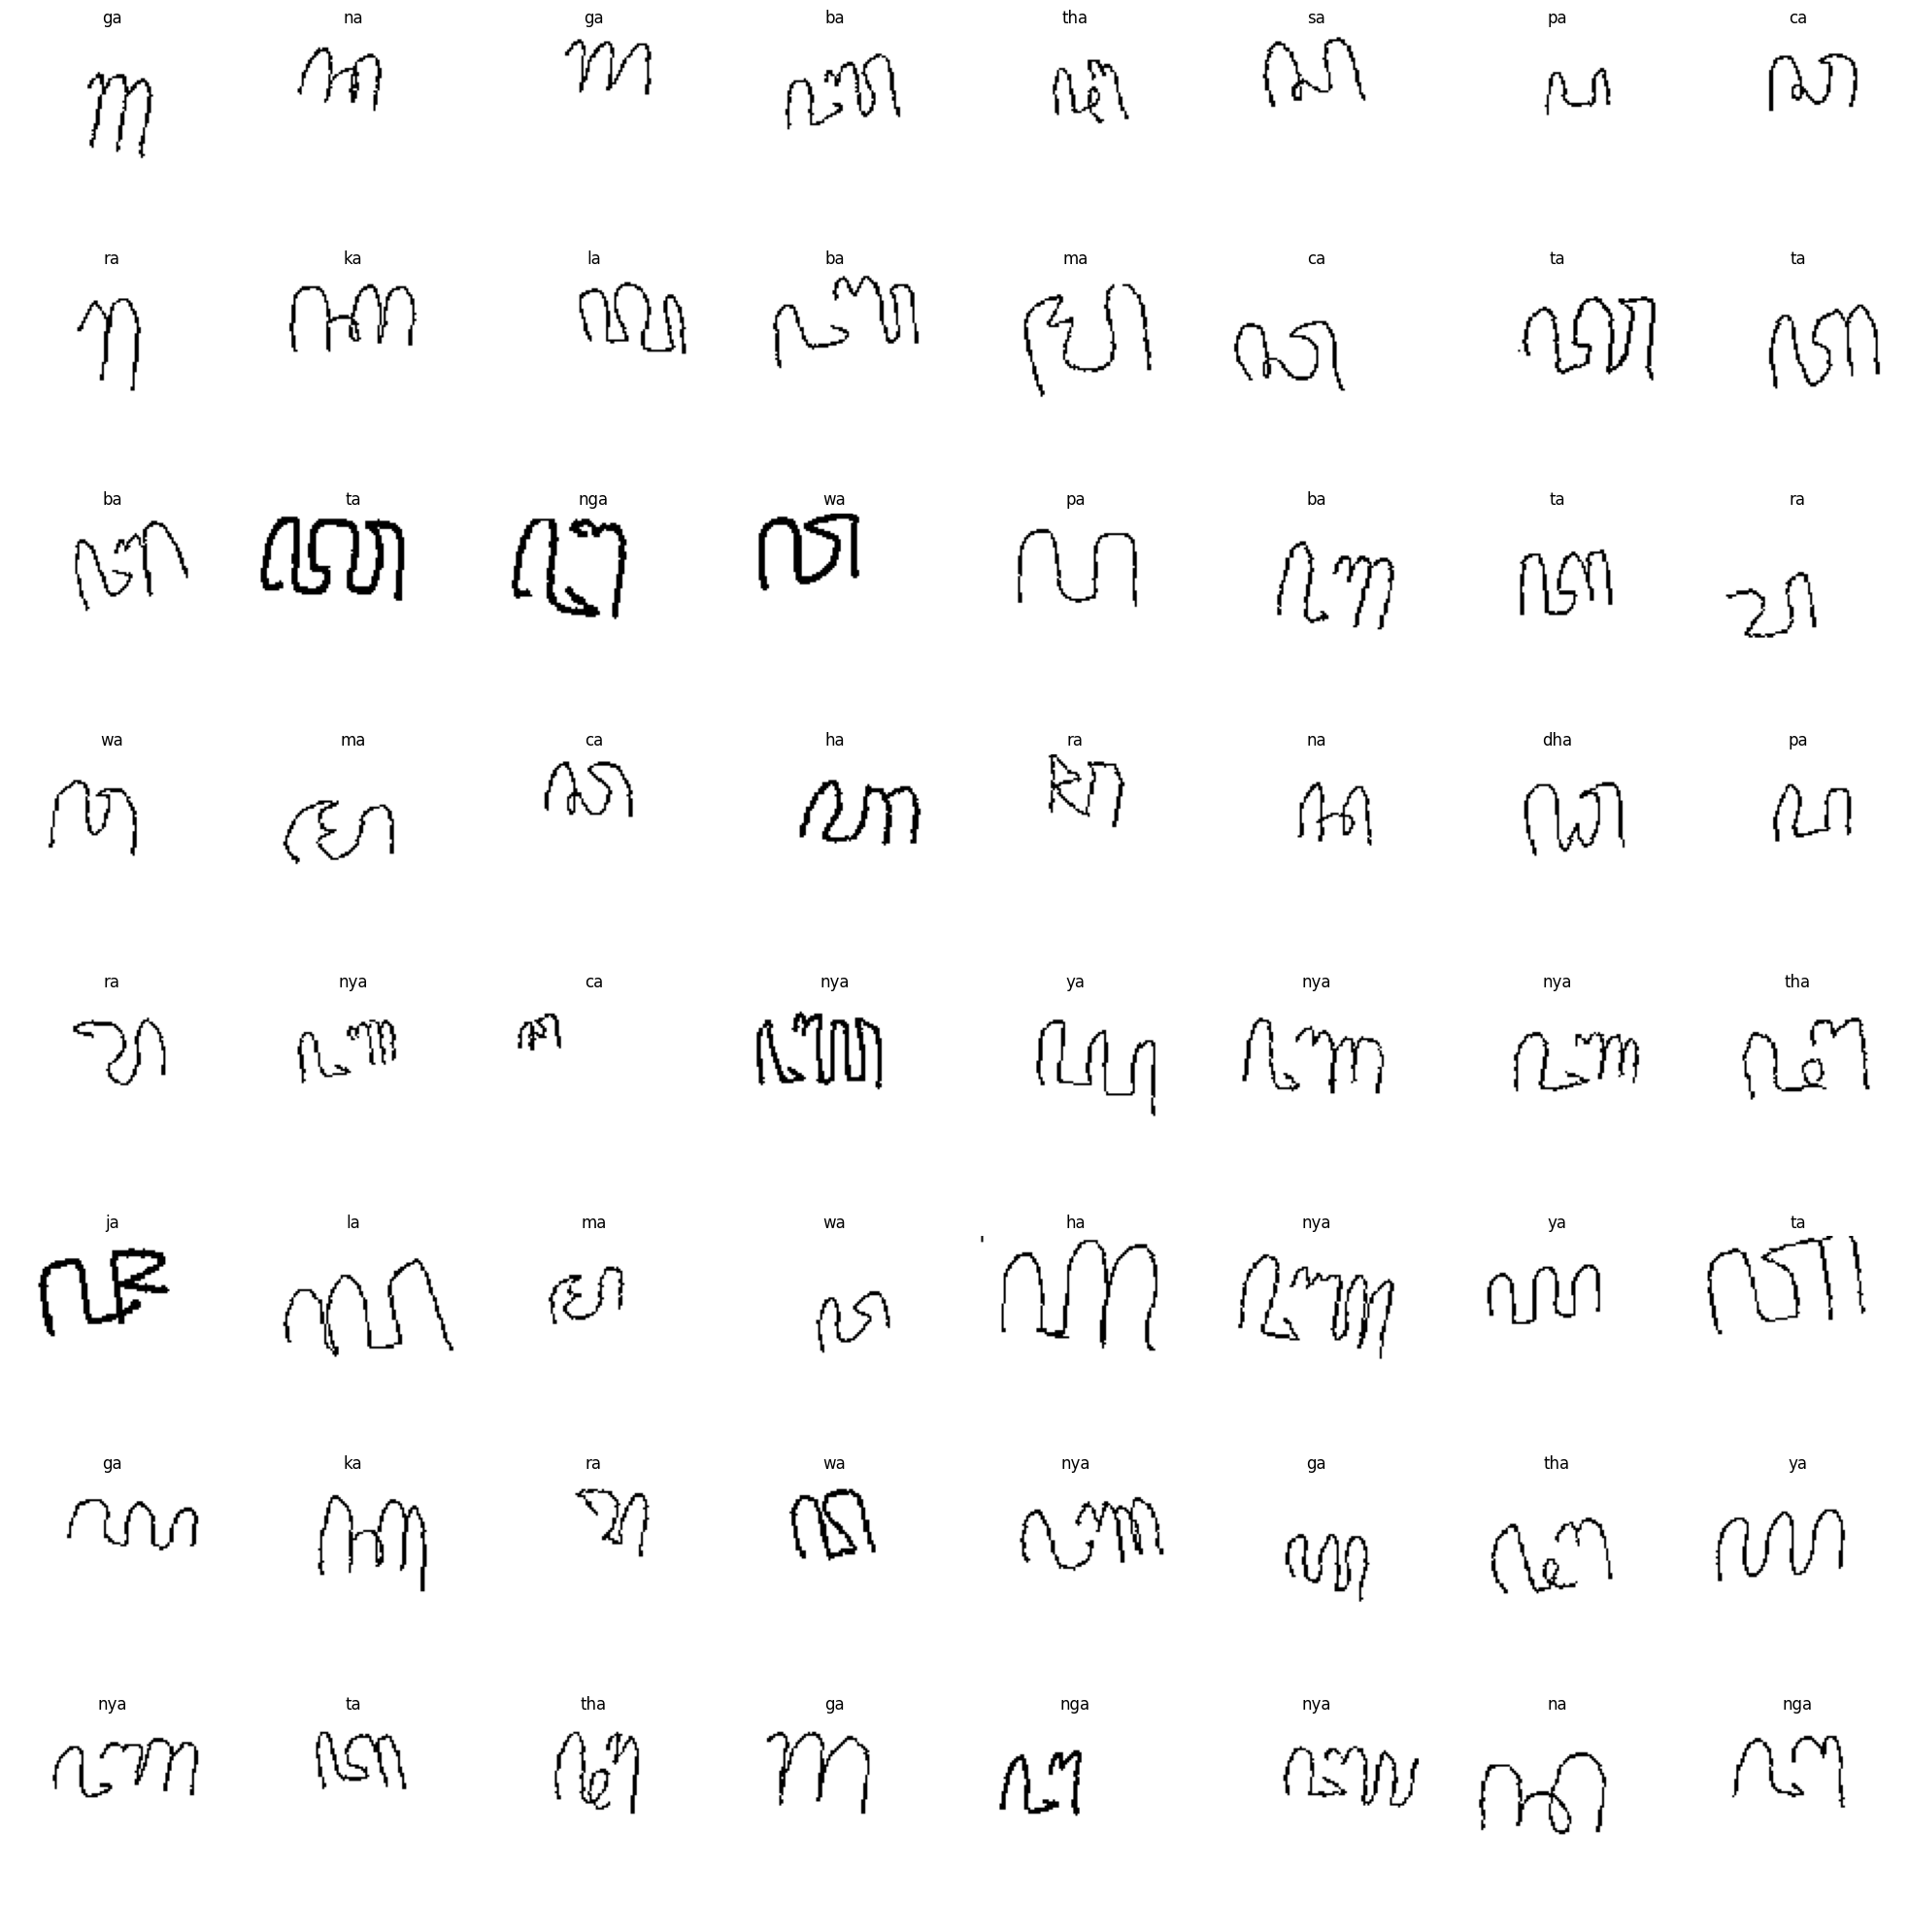

In [85]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20))

for img, label, ax in zip(feature, label, axs.flatten()):
    ax.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
    ax.axis('off')
    label = list(label_dict.keys())[list(label_dict.values()).index(label)]
    ax.set_title(label)
    
plt.tight_layout()
plt.show()

In [86]:
import torch.nn as nn
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import mobilenet_v2


class HanacarakaMobileNetV3(nn.Module):
    """
    MobileNetV3 were used as the baseline model. It's a CNN based architecture that were designed for mobile and edge devices.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        self.freeze()

        self.model.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)
    
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HanacarakaMobileNetV3(num_classes=len(label_dict)).to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [88]:
def train(
        model, train_loader, val_loader, criterion, optimizer, early_stop_epochs=5
):
    min_val_loss = float('inf')
    early_stop_counter = 0
    epoch = 0

    while True:
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for feature, label in train_loader:
            feature, label = feature.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(feature)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for feature, label in val_loader:
                feature, label = feature.to(device), label.to(device)

                output = model(feature)
                loss = criterion(output, label)

                val_loss += loss.item()

                _, predicted = torch.max(output.data, 1)
                total_preds += label.size(0)
                correct_preds += (predicted == label).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        print(
            f'Epoch {epoch+1} | '
            f'Train Loss: {train_loss/len(train_loader):.4f} | '
            f'Val Loss: {avg_val_loss:.4f} | '
            f'Val Accuracy: {val_accuracy:.4f} | '
        )

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_epochs:
            print('Early Stopping...')
            break

        epoch += 1

    return model

In [89]:
model = train(model, train_loader, val_loader, criterion, optimizer)

Epoch 1 | Train Loss: 2.9756 | Val Loss: 2.9682 | Val Accuracy: 0.1090 | 
Epoch 2 | Train Loss: 2.8339 | Val Loss: 2.8704 | Val Accuracy: 0.1282 | 
Epoch 3 | Train Loss: 2.6674 | Val Loss: 2.8217 | Val Accuracy: 0.1474 | 
Epoch 4 | Train Loss: 2.5604 | Val Loss: 2.6660 | Val Accuracy: 0.1987 | 
Epoch 5 | Train Loss: 2.4659 | Val Loss: 2.4248 | Val Accuracy: 0.2564 | 
Epoch 6 | Train Loss: 2.4899 | Val Loss: 2.3803 | Val Accuracy: 0.2949 | 
Epoch 7 | Train Loss: 2.4188 | Val Loss: 2.3060 | Val Accuracy: 0.3013 | 
Epoch 8 | Train Loss: 2.3624 | Val Loss: 2.2192 | Val Accuracy: 0.3205 | 
Epoch 9 | Train Loss: 2.3457 | Val Loss: 2.1921 | Val Accuracy: 0.3141 | 
Epoch 10 | Train Loss: 2.2949 | Val Loss: 2.2136 | Val Accuracy: 0.3013 | 
Epoch 11 | Train Loss: 2.2941 | Val Loss: 2.1744 | Val Accuracy: 0.3462 | 
Epoch 12 | Train Loss: 2.2742 | Val Loss: 2.1404 | Val Accuracy: 0.3910 | 
Epoch 13 | Train Loss: 2.2786 | Val Loss: 2.1379 | Val Accuracy: 0.3654 | 
Epoch 14 | Train Loss: 2.2410 | Va

In [90]:
model.unfreeze()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model = train(model, train_loader, val_loader, criterion, optimizer)

Epoch 1 | Train Loss: 2.0792 | Val Loss: 2.4172 | Val Accuracy: 0.2500 | 
Epoch 2 | Train Loss: 1.9266 | Val Loss: 1.8503 | Val Accuracy: 0.4231 | 
Epoch 3 | Train Loss: 1.7489 | Val Loss: 1.6519 | Val Accuracy: 0.4615 | 
Epoch 4 | Train Loss: 1.6618 | Val Loss: 1.5766 | Val Accuracy: 0.4936 | 
Epoch 5 | Train Loss: 1.5859 | Val Loss: 1.5452 | Val Accuracy: 0.5000 | 
Epoch 6 | Train Loss: 1.4670 | Val Loss: 1.4740 | Val Accuracy: 0.5128 | 
Epoch 7 | Train Loss: 1.4119 | Val Loss: 1.3587 | Val Accuracy: 0.5705 | 
Epoch 8 | Train Loss: 1.3667 | Val Loss: 1.2311 | Val Accuracy: 0.5577 | 
Epoch 9 | Train Loss: 1.2816 | Val Loss: 1.2296 | Val Accuracy: 0.5897 | 
Epoch 10 | Train Loss: 1.2578 | Val Loss: 1.1345 | Val Accuracy: 0.5962 | 
Epoch 11 | Train Loss: 1.1805 | Val Loss: 1.2144 | Val Accuracy: 0.6474 | 
Epoch 12 | Train Loss: 1.1070 | Val Loss: 1.0137 | Val Accuracy: 0.6474 | 
Epoch 13 | Train Loss: 1.0772 | Val Loss: 1.0845 | Val Accuracy: 0.6603 | 
Epoch 14 | Train Loss: 1.0220 | Va

In [91]:
model.unfreeze()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model = train(model, train_loader, val_loader, criterion, optimizer)

Epoch 1 | Train Loss: 0.3396 | Val Loss: 0.4997 | Val Accuracy: 0.8269 | 
Epoch 2 | Train Loss: 0.3456 | Val Loss: 0.5489 | Val Accuracy: 0.8333 | 
Epoch 3 | Train Loss: 0.3449 | Val Loss: 0.5194 | Val Accuracy: 0.8462 | 
Epoch 4 | Train Loss: 0.3427 | Val Loss: 0.5073 | Val Accuracy: 0.8462 | 
Epoch 5 | Train Loss: 0.3272 | Val Loss: 0.5341 | Val Accuracy: 0.8333 | 
Epoch 6 | Train Loss: 0.3169 | Val Loss: 0.4919 | Val Accuracy: 0.8397 | 
Epoch 7 | Train Loss: 0.3208 | Val Loss: 0.5035 | Val Accuracy: 0.8333 | 
Epoch 8 | Train Loss: 0.3236 | Val Loss: 0.5670 | Val Accuracy: 0.8333 | 
Epoch 9 | Train Loss: 0.2936 | Val Loss: 0.4896 | Val Accuracy: 0.8397 | 
Epoch 10 | Train Loss: 0.3413 | Val Loss: 0.5266 | Val Accuracy: 0.8333 | 
Epoch 11 | Train Loss: 0.3338 | Val Loss: 0.4943 | Val Accuracy: 0.8462 | 
Epoch 12 | Train Loss: 0.3049 | Val Loss: 0.5861 | Val Accuracy: 0.8333 | 
Epoch 13 | Train Loss: 0.3089 | Val Loss: 0.5044 | Val Accuracy: 0.8462 | 
Epoch 14 | Train Loss: 0.2982 | Va

In [92]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for feature, label in test_loader:
            feature, label = feature.to(device), label.to(device)
            
            output = model(feature)
            _, predicted = torch.max(output, 1)
            
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
    print(f'Accuracy: {correct/total:.4f}')
    
    return correct/total

In [93]:
test(model, test_loader)

Accuracy: 0.8471


0.8471337579617835

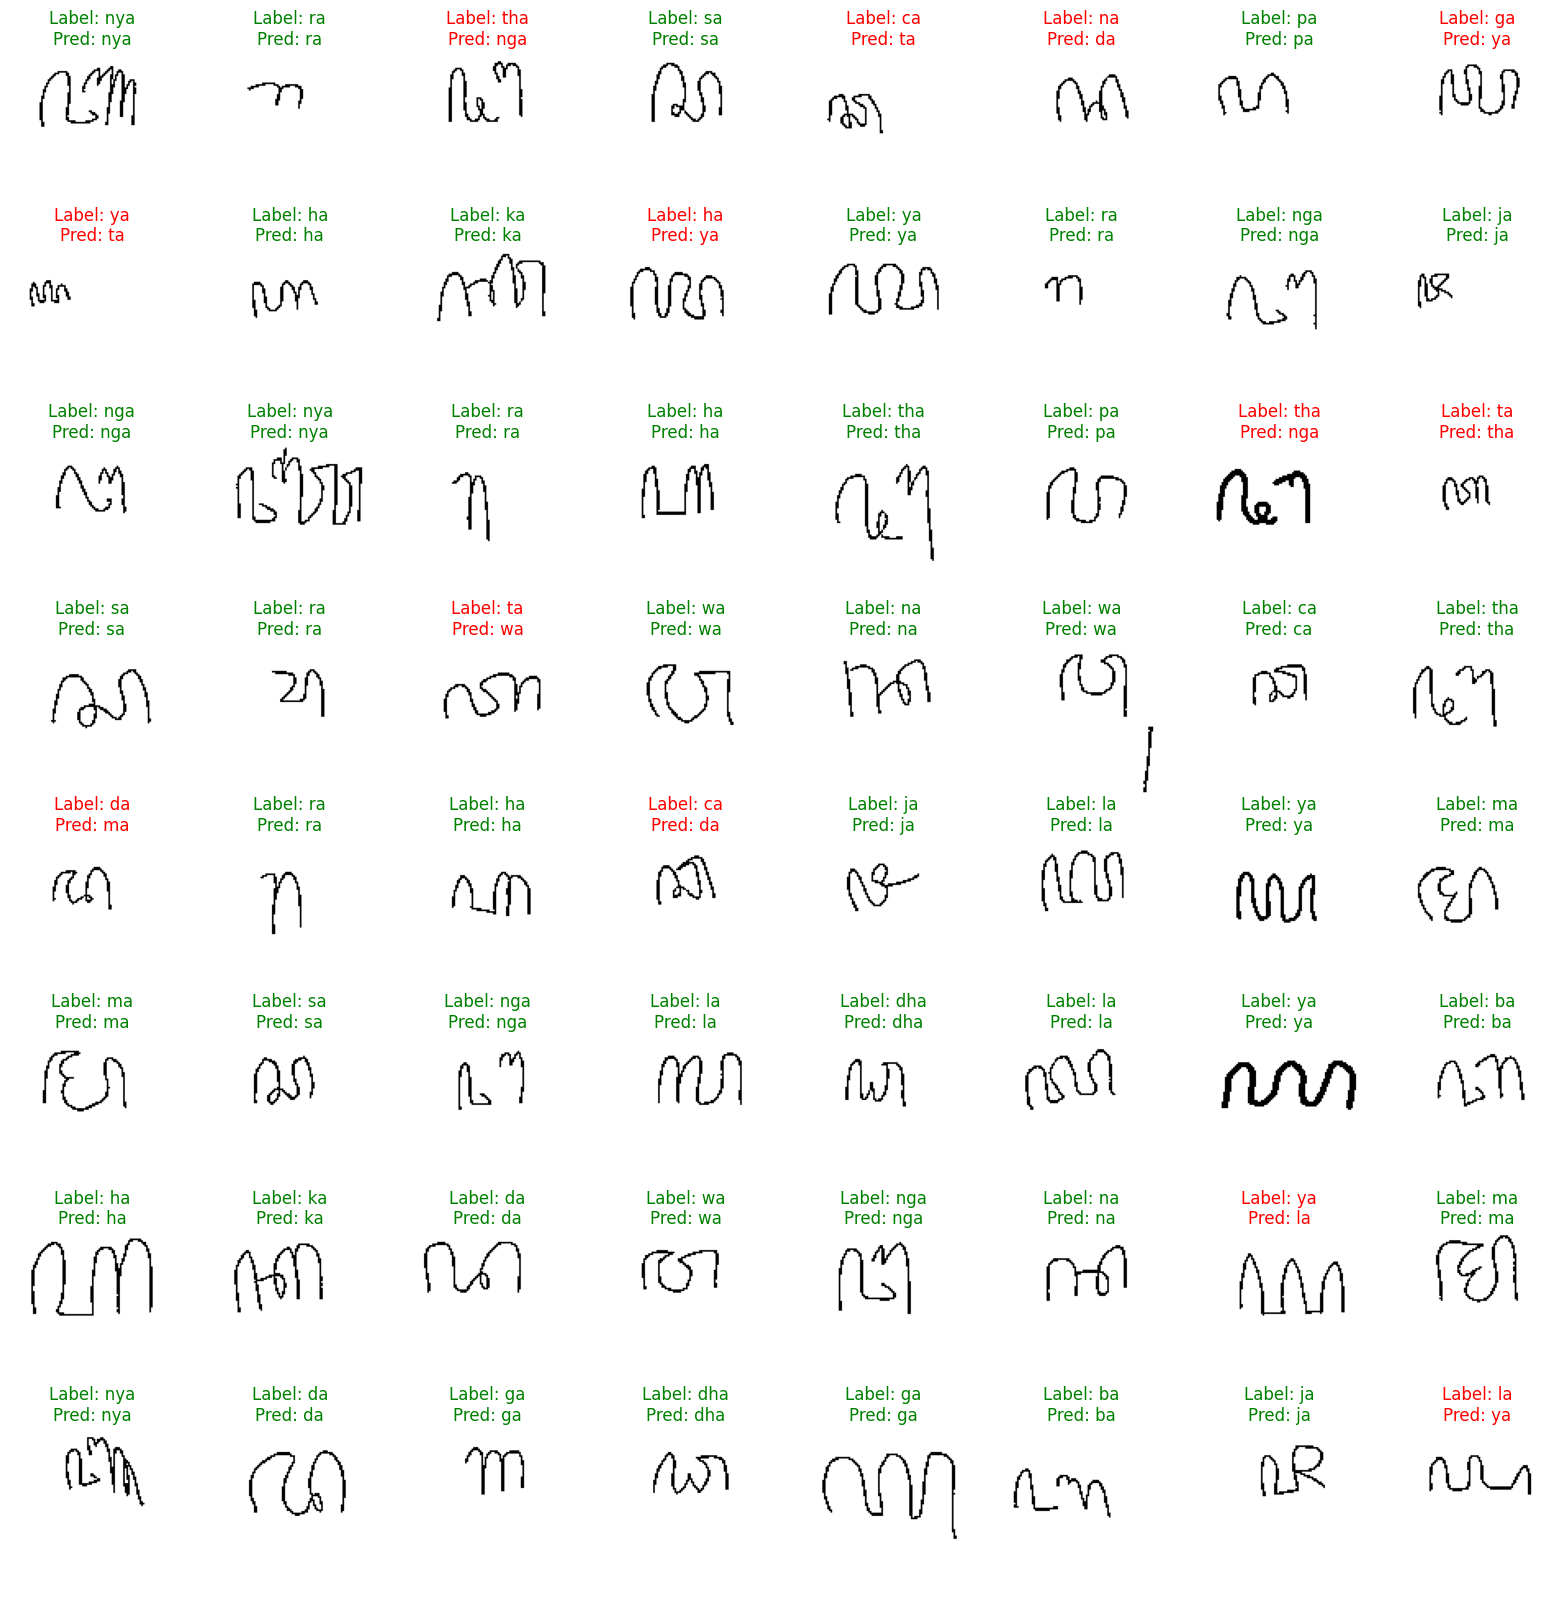

In [94]:
for feature, label in test_loader:
    feature, label = feature.to(device), label.to(device)
    output = model(feature)
    _, predicted = torch.max(output, 1)
    
    break
    
fig, axs = plt.subplots(8, 8, figsize=(20, 20))

for img, label, pred, ax in zip(feature, label, predicted, axs.flatten()):
    ax.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
    ax.axis('off')
    label = list(label_dict.keys())[list(label_dict.values()).index(label)]
    pred = list(label_dict.keys())[list(label_dict.values()).index(pred)]
    if label == pred:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f'Label: {label}\nPred: {pred}', color=color)